### Imports

In [1]:
import os
import sys
sys.path.append('../scripts')

import sentinel
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import distance
from geopy.point import Point
import yaml

from sentinelhub import (
    CRS,
    BBox,
    bbox_to_dimensions,
    SHConfig
)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Creditential

In [2]:
# Fetch credentials for modis
with open("../config.yaml") as file:
    credentials = yaml.safe_load(file)
user = credentials["sentinelhub"]["API_USER"]
password = credentials["sentinelhub"]["API_PASSWORD"]

config = SHConfig(
    sh_client_id = user,
    sh_client_secret = password
)

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


### Setup

In [3]:
# Bounding box coordinates
#(-124.45976373769807,48.62786844842075,-115.12341739786068,53.51536369187604)
lat_min = 48.62786844842075
lon_min = -124.45976373769807
lat_max = 53.51536369187604
lon_max = -115.12341739786068

#Desired spacing in kilometers between each image
spacing_km = 150

#Desired resolution of each image
resolution = 300

# Not used for now
start_date = "2021-06-29"
end_date = "2021-08-30"

sentinel_request_dir = "../data/sentinel/request"
sentinel_tiff_dir = "../data/sentinel/tiff"
sentinel_merge_dir = "../data/sentinel/merge"

### Get points and bbox for the selected area

In [4]:
points, max_points_in_line, num_lines, points_per_line = sentinel.generate_grid_within_box(lat_min, lon_min, lat_max, lon_max, spacing_km)
points = [(y, x) for x, y in points]
    
aoi_bbox_list = []
for point in points:
    aoi_coords_wgs842 = sentinel.boundingBox(point[0],point[1],spacing_km/2)
    aoi_bbox_list.append(BBox(bbox=aoi_coords_wgs842, crs=CRS.WGS84))

aoi_size = bbox_to_dimensions(aoi_bbox_list[1], resolution=resolution)

## Print informations

In [5]:
print("Number of points per line: ", max_points_in_line)
print("Number of lines: ", num_lines)
print("Total number of points generated: ", len(points))
print("List of number of points per line: ", points_per_line)
print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Number of points per line:  5
Number of lines:  4
Total number of points generated:  20
List of number of points per line:  [5, 5, 5, 5]
Image shape at 300 m resolution: (496, 506) pixels


In [6]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}

function evaluatePixel(sample) {
    let val = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    let imgVals = null;
    
    if (val<-1.1) imgVals = [0,0,0];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86];
    else if (val<0) imgVals = [1,1,0.88];
    else if (val<0.025) imgVals = [1,0.98,0.8];
    else if (val<0.05) imgVals = [0.93,0.91,0.71];
    else if (val<0.075) imgVals = [0.87,0.85,0.61];
    else if (val<0.1) imgVals = [0.8,0.78,0.51];
    else if (val<0.125) imgVals = [0.74,0.72,0.42];
    else if (val<0.15) imgVals = [0.69,0.76,0.38];
    else if (val<0.175) imgVals = [0.64,0.8,0.35];
    else if (val<0.2) imgVals = [0.57,0.75,0.32];
    else if (val<0.25) imgVals = [0.5,0.7,0.28];
    else if (val<0.3) imgVals = [0.44,0.64,0.25];
    else if (val<0.35) imgVals = [0.38,0.59,0.21];
    else if (val<0.4) imgVals = [0.31,0.54,0.18];
    else if (val<0.45) imgVals = [0.25,0.49,0.14];
    else if (val<0.5) imgVals = [0.19,0.43,0.11];
    else if (val<0.55) imgVals = [0.13,0.38,0.07];
    else if (val<0.6) imgVals = [0.06,0.33,0.04];
    else imgVals = [0,0.27,0];
    
    imgVals.push(sample.dataMask)
    
    return imgVals
}
"""

In [7]:
evalscript2 = """
//VERSION=3
function setup() {
    return {
        input: ["B08", "B04", "B03", "SCL"],
        output: { bands: 4 }
    };
}

function evaluatePixel(sample) {
    if (sample.SCL == 3 || sample.SCL == 8 || sample.SCL == 9 || sample.SCL == 10) {
        // Return transparent for clouds, shadows, and snow
        return [0, 0, 0, 0];
    }
    return [sample.B08, sample.B04, sample.B03, 1];
}
"""

## Get data

In [8]:
ndvi_img_list = []
for aoi_bbox in aoi_bbox_list:
    ndvi_img = sentinel.get_ndvi_img(aoi_bbox,aoi_size,sentinel_request_dir,start_date,end_date,evalscript_ndvi,config) ##!! start_date and end_date are not used
    ndvi_img_list.append(ndvi_img)

### Concatenation in a tiff file

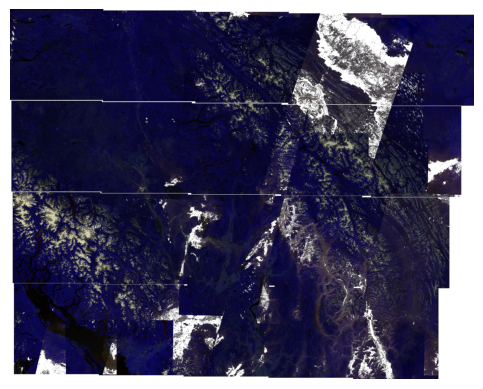

In [9]:
sentinel.concatenate_tiff_images(sentinel_request_dir,sentinel_tiff_dir, sentinel_merge_dir)
 